# Data Exploration / Testing Algorithms

Dataset: https://snap.stanford.edu/data/soc-RedditHyperlinks.html

Political subreddits list: https://github.com/valentinhofmann/politosphere/blob/main/data/subreddits.txt


## Dataset information
- **SOURCE_SUBREDDIT**: the subreddit where the link originates
- **TARGET_SUBREDDIT**: the subreddit where the link ends
- **POST_ID**: the post in the source subreddit that starts the link
- **TIMESTAMP**: time time of the post
- **POST_LABEL**: label indicating if the source post is explicitly negative towards the target post. The value is -1 if the source is negative towards the target, and 1 if it is neutral or positive. The label is created using crowd-sourcing and training a text based classifier, and is better than simple sentiment analysis of the posts. Please see the reference paper for details.
- **POST_PROPERTIES**: a vector representing the text properties of the source post, listed as a list of comma separated numbers. The vector elements are the following:
1. Number of characters
2. Number of characters without counting white space
3. Fraction of alphabetical characters
4. Fraction of digits
5. Fraction of uppercase characters
6. Fraction of white spaces
7. Fraction of special characters, such as comma, exclamation mark, etc.
8. Number of words
9. Number of unique works
10. Number of long words (at least 6 characters)
11. Average word length
12. Number of unique stopwords
13. Fraction of stopwords
14. Number of sentences
15. Number of long sentences (at least 10 words)
16. Average number of characters per sentence
17. Average number of words per sentence
18. Automated readability index
19. Positive sentiment calculated by VADER
20. Negative sentiment calculated by VADER
21. Compound sentiment calculated by VADER

22-86. LIWC Variables

In [11]:
import pandas as pd
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df = pd.read_csv('data/filtered_network.csv')
clustering_score = pd.read_csv('data/score_plus_clusters.csv')

In [13]:
source = "SOURCE_SUBREDDIT"
target = "TARGET_SUBREDDIT"
edgelist = df.loc[:, [source, target]].copy()
edgelist_df = edgelist.drop_duplicates().copy()
edgelist_df["count"] = edgelist.groupby([source, target]).transform("size")
# create graph
G = nx.from_pandas_edgelist(edgelist_df, source=source, target=target, create_using=nx.DiGraph(),edge_attr="count")
# convert to adjacency matrix
adj_matrix = nx.to_pandas_adjacency(G, weight="count")

In [14]:

# add link sentiments
df_counts = df.groupby([source, target])['LINK_SENTIMENT'].value_counts().reset_index()
links = df_counts.groupby(['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT', 'LINK_SENTIMENT'])['count'].sum().unstack(fill_value=0).reset_index().rename(columns={1: 'POSITIVE', -1: 'NEGATIVE'})
edgelist_df = edgelist_df.merge(links, how='inner', on=[source,target])
edgelist_df["LINK_SENTIMENT"] = edgelist_df["POSITIVE"] - edgelist_df["NEGATIVE"]
G_directed = nx.from_pandas_edgelist(edgelist_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count", "POSITIVE", "NEGATIVE", "LINK_SENTIMENT"])
G_undirected = G_directed.to_undirected()

In [15]:
def best_louvain_partition(G):

    best_modularity = -1
    best_partition = None
    for i in range(50):
        partition = community_louvain.best_partition(G, weight='count', random_state=i)
        modularity_value = community_louvain.modularity(partition, G)
        if modularity_value > best_modularity:
            best_modularity = modularity_value
            best_partition = partition
    return best_partition

partition = best_louvain_partition(G_undirected) 

nx.set_node_attributes(G_undirected, partition, 'community')
nx.set_node_attributes(G_directed, partition, 'community')

# transform to list of community sets
partition_df = pd.DataFrame({'subreddit': partition.keys(), 'community':partition.values()})
communities = partition_df.groupby(by='community').agg(set)['subreddit'].tolist()

# Select the top three nodes with the highest degree in each community for labeling
community_labels = {}
for community in set(partition.values()):
    community_nodes = [node for node in partition if partition[node] == community]
    
    top_nodes = sorted(community_nodes, key=lambda node: G_undirected.degree(node), reverse=True)[:3]

    community_labels[community] = top_nodes

# Add communities to dataframe
df["SOURCE_COMMUNITY"] = df['SOURCE_SUBREDDIT'].map(partition)
df["TARGET_COMMUNITY"] = df['TARGET_SUBREDDIT'].map(partition)

In [16]:
from collections import defaultdict

# Create a dictionary to store nodes for each community
communities = defaultdict(list)

# Populate the dictionary
for node, community in partition.items():
    communities[community].append(node)

# Now, `communities` contains a list of nodes for each community
for community, nodes in communities.items():
    print(f"Community {community}: {nodes}")
    print(f"Number of subreddits: {len(nodes)}\n")  


Community 0: ['libertarian', 'conservative', 'enoughlibertarianspam', 'liberal', 'libertariandebates', 'new_right', 'progun', 'climateskeptics', 'askaconservative', 'republican', 'prolife', 'prochoice', 'whiterights', 'shitpoliticssays', 'shitrconservativesays', 'paleoconservative', 'gunpolitics', 'randpaul', 'conservatives_r_us', 'conservativemeta', 'austrian_economics', 'actualconspiracies', 'libertarianmeme', 'conservatives', 'nevertrump', 'newjerseylibertarians', 'demsocialist', 'geolibertarianism', 'libertarianpartyohio', 'libertarianpartyusa', 'conservativesonly', 'thedavidpakmanshow', 'acteuropa', 'antiwar', 'conservativelounge', 'daverubin', 'theredpillright', 'georgism']
Number of subreddits: 38

Community 1: ['communism101', 'communism', 'mensrightsmeta', 'mensrights', 'socialism', 'law', 'socialistprogrammers', 'alltheleft', 'againstmensrights', 'progressive', 'canadapolitics', 'feminismformen', 'shittankiessay', 'shitliberalssay', 'socialists', 'leftcommunism', 'socialistra

In [17]:
df['Louvain_Community_Source'] = df['SOURCE_SUBREDDIT'].map(partition)
df['Louvain_Community_Target'] = df['TARGET_SUBREDDIT'].map(partition)

In [18]:
# Prepare a mapping of subreddits to Louvain communities
louvain_community_mapping = pd.concat([
    df[['SOURCE_SUBREDDIT', 'Louvain_Community_Source']].rename(columns={'SOURCE_SUBREDDIT': 'subreddit', 'Louvain_Community_Source': 'Louvain_Community'}),
    df[['TARGET_SUBREDDIT', 'Louvain_Community_Target']].rename(columns={'TARGET_SUBREDDIT': 'subreddit', 'Louvain_Community_Target': 'Louvain_Community'})
]).drop_duplicates()

# Merge Louvain community and embedding clusters
merged = pd.merge(clustering_score, louvain_community_mapping, on='subreddit', how='inner')


In [19]:
contingency_table = pd.crosstab(merged['Louvain_Community'], merged['Cluster'])
print(contingency_table)

Cluster             0   1  2   3  4  5
Louvain_Community                     
0                   0   3  0  31  0  4
1                   0  11  0  33  0  4
2                   0   0  0  19  9  2
3                   2   0  0  52  2  0
4                  59   0  0   1  0  0
5                   0   0  9   3  0  0


In [20]:
# Create a manual mapping dictionary
manual_mapping = {
    0: 3,  
    1: 1,  
    2: 4, 
    3: 5,  
    4: 0, 
    5: 2   
}

# Apply the mapping to your Louvain labels
merged['Remapped_Cluster'] = merged['Louvain_Community'].map(manual_mapping)

# Validate the new mapping
print(merged[['Louvain_Community', 'Remapped_Cluster']].head())

   Louvain_Community  Remapped_Cluster
0                  0                 3
1                  0                 3
2                  1                 1
3                  1                 1
4                  1                 1


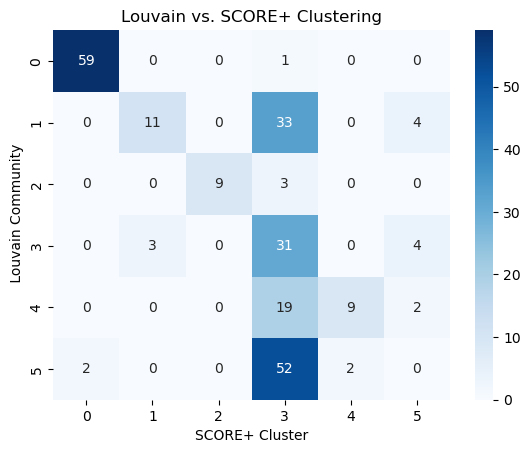

In [21]:
remapped_clusters = merged['Louvain_Community'].map(manual_mapping)
contingency_table_remapped = pd.crosstab(remapped_clusters, merged['Cluster'])

sns.heatmap(contingency_table_remapped, annot=True, fmt="d", cmap="Blues")
plt.title("Louvain vs. SCORE+ Clustering")
plt.xlabel("SCORE+ Cluster")
plt.ylabel(" Louvain Community")
plt.show()

In [ ]:
diff_rows = merged[remapped_clusters != merged['Cluster']]
differing_subreddits = diff_rows['subreddit'].unique()

['mensrightsmeta' 'mensrights' 'politicaldiscussion' 'politics'
 'socialism' 'postnationalist' 'law' 'economy' 'politic' 'altnewz'
 'agitation' 'worldpolitics' 'againstmensrights' 'badeconomics'
 'progressive' 'metanarchism' 'whiterights' 'syriancivilwar'
 'politicalmoderation' 'badpolitics' 'democrats' 'ukpolitics' 'ncpolitics'
 'futuristparty' 'restorethefourth' 'shitrconservativesays'
 'paleoconservative' 'canadapolitics' 'feminismformen' 'censorship'
 'shitliberalssay' 'conservatives_r_us' 'socialists' 'ask_politics'
 'anarchocommunism' 'occupywallstreet' 'politicalphilosophy'
 'leftcommunism' 'neutralpolitics' 'socialistra' 'scotus'
 'enoughsandersspam' 'chomsky' 'justiceporn' 'politicalfactchecking'
 'moderatepolitics' 'inthenews' 'trump16' 'anarchy' 'gulag' 'civpolitics'
 'shitguncontrollerssay' 'kasichforpresident' 'canadapolitic'
 'socialanarchism' 'ndp' 'atheismplus' 'potuselection2016' 'obama'
 '2016_elections' 'europes' 'explainmydownvotes' 'trueprogressive'
 'hillaryclinto

In [23]:
summary_diff = diff_rows.groupby(['Cluster', 'Louvain_Community'])['subreddit'].apply(list).reset_index()
summary_diff.columns = ['SCORE+ Cluster', 'Louvain Community', 'Subreddits']
summary_diff

,SCORE+ Cluster,Louvain Community,Subreddits
0,0,3,"[stillsandersforpres, politicalrevolutionca]"
1,1,0,"[thedavidpakmanshow, daverubin, georgism]"
2,3,1,"[mensrights, socialism, law, againstmensrights..."
3,3,2,"[politicaldiscussion, postnationalist, agitati..."
4,3,3,"[politics, economy, politic, altnewz, badecono..."
5,3,4,[kossacks_for_sanders]
6,3,5,"[ukpolitics, europes, europeannationalism]"
7,4,3,"[neutralnews, justiceserved]"
8,5,0,"[whiterights, shitrconservativesays, paleocons..."
9,5,1,"[mensrightsmeta, feminismformen, scotus, socia..."
